# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration

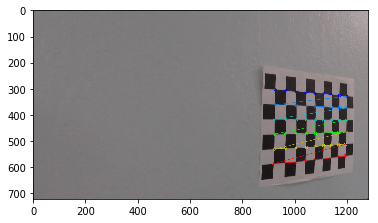

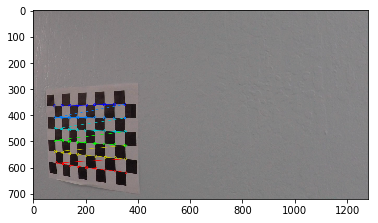

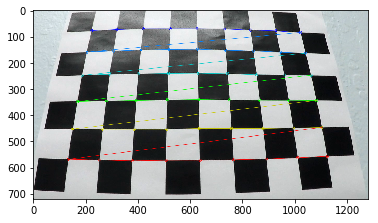

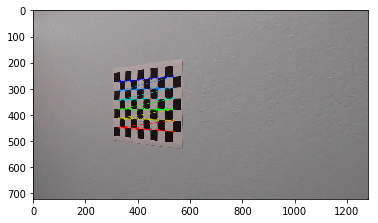

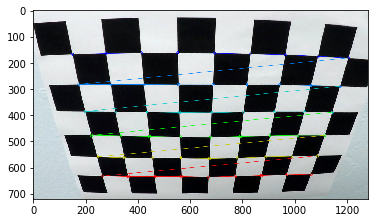

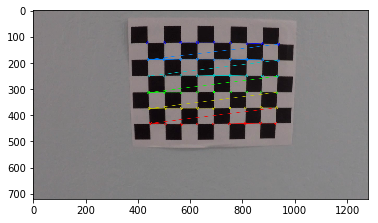

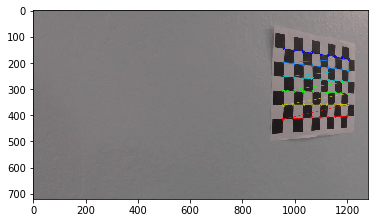

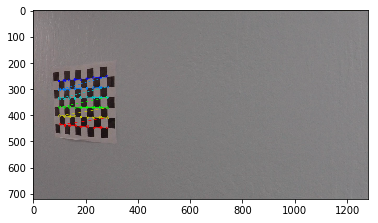

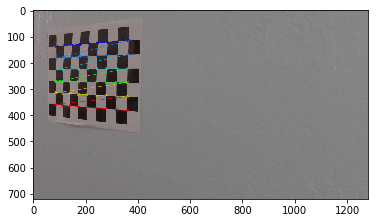

KeyboardInterrupt: 

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

# Finnaly, compute the camera calibration matrix and distortion coefficients 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print('Camera calibrated')

---
## Parameters

In [ ]:
#Mask
t_l=(0.45,0.59)
t_r=(0.55.0.59)
b_l=(0,1)
b_r=(1,1)
vertices = np.array([[(x_max*b_l[0], y_max*b_l[1]), (x_max * t_l[0], y_max * 0.59), (x_max * 0.55, y_max * 0.59), (x_max, y_max)]], dtype=np.int32)


# Color thresholds
s_thresh = (170,255)

# Gradient thresholds
x_thresh = (30,100)
y_thresh = (20,100)
mag_thresh = (50,150)
dir_thresh=(0.7,1.3)

# Gradient kernel sizes
x_ksize = 3
y_ksize = 3
mag_ksize = 9
dir_ksize = 15

# Sliding window properties 
nwindows=9
window_margin=100 
minpix=50
search_poly_margin = 100

# Line finding parameters
num_look_back = 10
max_fails = 5

# Sanity parameters
curve_threshold = 10000
lane_width_thresholds = [3,5]

#Convertion parameters
xm_px = 3.7/500
ym_px = 30/1000

---
## Helper functions

In [ ]:

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def undistort(img):
    """Applies a distortion correction to raw images"""
    return cv2.undistort(img, mtx, dist)


def abs_sobel_threshold(gray, ksize, thresh, orient='x'):
    """Calculate directional gradient and apply threshold"""
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    elif orient=='y': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    else: 
        print("Unknown orient for abs_sobel_treshold")
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output


def mag_threshold(gray, ksize, thresh):
    """Calculate gradient magnitude and apply threshold"""
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * mag / np.max(mag))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output


def dir_threshold(gray, ksize, thresh):
    """Calculate gradient direction and apply threshold"""
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



def apply_thresholds(img, s_thresh, x_thresh, x_ksize, y_thresh, y_ksize, mag_thresh, mag_ksize, dir_thresh, dir_ksize):
    img = np.copy(img)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #Threshold directional gradients
    gradx = abs_sobel_threshold(l_channel, x_ksize, x_thresh, orient='x')
    grady = abs_sobel_threshold(l_channel, y_ksize, y_thresh, orient='y')
    
    
    #Threshold gradient magnitude
    mag_binary = mag_threshold(l_channel, mag_ksize, mag_thresh)
    
    #Threshold gradient direction
    dir_binary = dir_threshold(l_channel,dir_ksize,dir_thresh)
    
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary==1) & (dir_binary==1))] = 1 
 
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color = np.dstack(( np.zeros_like(s_binary), s_binary, combined)) * 255
    
    # Binary
    binary = np.zeros_like(gradx)
    binary[((s_binary==1) | (combined==1))] = 1
    
    return color, binary #? hva er forskjellen

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def fit_poly(img_shape, leftx, lefty, rightx, righty, to_meters=False):
    # Fit a second order polynomial to each with np.polyfit() ###
    if not to_meters:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        left_fit = np.polyfit(lefty*ym_px, leftx*xm_px, 2)
        right_fit = np.polyfit(righty*ym_px, rightx*xm_px, 2)       

    # Generate x and y values
    y = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]

    return left_fit, right_fit, left_x, right_x, y



def transform_perspective(img):
    
    src = np.float32([[572,465],[712,465],[273,665],[1033,665]])
    xmax =img.shape[1]
    ymax=img.shape[0]
    dst = np.float32([[xmax*0.3, ymax*0.3], [xmax*0.7, ymax*0.3],[xmax*0.3, ymax],[xmax*0.7, ymax]])
    # M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Minv, the inverse perspective transform 
    # warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (xmax,ymax), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def project_lanes_onto_original_image(shape, warped_binary, undist, left_x, right_x, y, Minv): 
    """todo"""
    if left_x is None or right_x is None:
        return undist
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (shape[1], shape[0])) 
    # Combine the result with the original image
    original_image_with_lanes = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Return original image with detected lanes 
    return original_image_with_lanes

def measure_curvature_pixels(y, fit):
    """
    Calculate the curvature of polynomial functions in pixels, using the formula:
    R = (1+(f'(y))^2)^(3/2) / |f''(y)|
    f(y) = Ay^2 + By + C
    """

    # Choosing the y at the bottom of the image to estimate the curvature
    y_eval = np.max(y)
    
    curve = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    # Calculating the radius of curvature for the lanes
    return curve


def average_lane_width(left_x, right_x, to_real=True):
    """
    Measures the distance between the lines at the bottom, middle and top of the road,
    returning the average distance from the three points
    """
    width_low = right_x[-1]-left_x[-1]
    width_middle = right_x[len(left_x)//2]-left_x[len(left_x)//2]
    width_high = right_x[0]-left_x[0]

    average_length = np.mean([width_low, width_middle, width_high])

    return average_length*xm_px

def sanity_check(left_fit, right_fit, left_x, right_x, y, curve_threshold, lane_width_thresholds):
    """
    Performs a sanity check on two lines, evaluating avg distance and similarity in curvature 
    Returns True if the lines make sense , or False if they dont make sende
    """


    # Calculate curvature radius of left line and right line
    left_rad = measure_curvature_pixels(y, left_fit)
    right_rad = measure_curvature_pixels(y, right_fit)

    # Calculate avarega lane width
    avg_width = average_lane_width(left_x, right_x)

    # Checking if the curvatures of the lines are similar enough
    if(abs(left_rad-right_rad) >= curve_threshold):
        return False
    # Checking if the width between the lines makes sense
    elif(avg_width < lane_width_thresholds[0] or avg_width> lane_width_thresholds[1]):
        return False  
    else:
        return True

--- 
## Line Class

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.not_detected = 0
        
        # Stores coefficients
        self.last_fits = []
        self.best_fit = None
        self.current_fit = None
        
        # Stores x values
        self.last_xs = []
        self.best_x = None
        self.current_x = None
        
    def reset(self):
        self.__init__()


    def update(self, x, fit, sanity):
        if not sanity:
            self.not_detected += 1
        else:  
            self.last_fits.append(fit)
            self.current_fit = fit
            
            self.last_xs.append(x)
            self.current_x = x
    
            if len(self.last_fits)>=num_look_back:
                self.last_fits.pop(0)
                self.last_xs.pop(0)
            
            
            self.best_fit = np.mean(self.last_fits, axis=0)
            self.best_x = np.mean(self.last_xs, axis=0)

               
        if self.not_detected > max_fails:
            self.reset()


--- 
## Finding Lanes 

In [ ]:
def sliding_windows(img, nwindows, margin, minpix, debug=False ):
    """Using peaks in histogram to find the starting points of the lanes 
    and then using sliding windows to find the positions of the rest of the left and right lane pixels"""
    

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if debug:
        out_img = np.dstack((img, img, img))
        
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if(debug):
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
  
            

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if debug:
        out_img[lefty,leftx] = [255,0,0]
        out_img[righty,rightx] = [0,0,255]
        print("Sliding windows:")
        plt.imshow(out_img)
        plt.show()
        
    return leftx, lefty, rightx, righty 


def search_around_poly(img, left_fit,right_fit, margin, debug=False):

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Find search area of actuvated x-values, within the margin of the polynomial function
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy) + left_fit[2] - margin) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy) + left_fit[2] + margin))
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy) + right_fit[2] - margin) &
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy) + right_fit[2] + margin))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def find_lane_pixels(img, nwindows, margin_window, margin_poly_search, minpix, debug=False):
    """ Takes an binary warped image and returns it with lanes drawn onto it """
    
    if(left_line.current_fit is None or right_line.current_fit is None):
        # Finding lane pixels 
        leftx, lefty, rightx, righty = sliding_windows(img, nwindows, margin_window, minpix, debug=debug)
    else: 
        leftx, lefty, rightx, righty =  search_around_poly(img,left_line.current_fit,right_line.current_fit, margin_poly_search)


    return leftx, lefty, rightx, righty




---
## Main pipeline

In [ ]:
import time

def process_image(img, debug=False):
    """
    Takes the original image, and returns it with the detected lanes drwan onto it. 
    This is done by: undistorting image, applying color and gradient tresholds, selecting region of interest, 
    performing perspective transform,  detecting lanes, transforming lanes back to original image 
    and drawing them onto original image
    """
    
    
    
    if debug:
        timers=[]
        print("0. Start")
        timers.append(time.time())
        
        print('Raw image')
        plt.imshow(img)
        plt.show()
    
    undist = undistort(img)
    
    if debug:
        timers.append(time.time())
        print('1. Undistorted image')
        plt.imshow(undist)
        plt.show()
        
    stacked, binary = apply_thresholds(undist, s_thresh, x_thresh, x_ksize, y_thresh, y_ksize, mag_thresh, mag_ksize, dir_thresh, dir_ksize)
    
    y_max = img.shape[0]
    x_max = img.shape[1]
    
    
    binary = region_of_interest(img=binary, vertices=vertices)
    
    if debug:
        print('2. Stacked thresholds (blue = gradient, green = color)')
        timers.append(time.time())
        plt.imshow(stacked)
        plt.show()
        
        print('2. Binary thresholds (masked)')
        plt.imshow(binary, cmap="gray")
        plt.show()
    
    warped, M, Minv = transform_perspective(undist)
    warped_binary, M, Minv = transform_perspective(binary)

    if debug:
        timers.append(time.time())
        print('3. Perspective change: warped')
        plt.imshow(warped)
        plt.show()
        print('3. Perspective change: warped binary')
        plt.imshow(warped_binary, cmap ="gray")
        plt.show()
        
    raw_left_x, raw_left_y, raw_right_x, raw_right_y = find_lane_pixels(warped_binary, nwindows, window_margin, search_poly_margin, minpix, debug=debug)

    left_fit, right_fit, left_x, right_x, y = fit_poly(warped_binary.shape, raw_left_x, raw_left_y, raw_right_x, raw_right_y)

    if debug:
        print("4. Fit Lines")
        timers.append(time.time())
        plt.plot(left_x, y, color="red")
        plt.plot(right_x, y, color="blue")
        plt.imshow(warped)
        plt.show()
    
    print("Width:", average_lane_width(left_x, right_x))
    
    lc = measure_curvature_pixels(y, left_fit)
    rc = measure_curvature_pixels(y, right_fit)
    print("Left:", lc)
    print("Right:", rc)
    print("Diff", abs(rc-lc))
    sanity = True
    
    left_line.update(left_x, left_fit, sanity)
    right_line.update(right_x, right_fit ,sanity)
    
    img_with_lanes = project_lanes_onto_original_image(warped_binary.shape, warped_binary, undist, left_line.best_x, right_line.best_x, y, Minv)
    
    if debug: 
        print('5. Original image with detected lanes')
        timers.append(time.time())
        plt.imshow(img_with_lanes)
        plt.show()
        
        
    if(debug):
        total = timers[-1]-timers[0]
        
        for i in range(1,len(timers)):
            print(i, ((timers[i]-timers[i-1])*100)/total,"%")
    return img_with_lanes
    #return warped_binary, undist, left_fitx, right_fitx, ploty
    

---
## Test

In [ ]:

left_line = Line()
right_line = Line()

images = glob.glob('./test_images/*')


"""
# Make a list of test images 

img = mpimg.imread('test_images/test1.jpg')
img_with_lanes = process_image(img, debug=True)

plt.imshow(img_with_lanes)
plt.show()
"""

# Iterate over all test images and show the detected lanes 
for fname in images:
    left_line = Line()
    right_line = Line()
    img = mpimg.imread(fname)
    img_with_lanes = process_image(img, debug=True)
    plt.imshow(img_with_lanes)
    plt.show()




---
## Test on videoes

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
"""

left_line = Line()
right_line = Line()

#clip1_output = "test_videos_output/project_video.mp4"
#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
#clip1_processed = clip1.fl_image(process_image) # NOTE: this fucntion excepts color images

clip2_output = "test_videos_output/challenge_video.mp4"
clip2 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip2_processed = clip2.fl_image(process_image) # NOTE: this fucntion excepts color images

%time clip2_processed.write_videofile(clip2_output, audio=False)

"""

'\n\nleft_line = Line()\nright_line = Line()\n\n#clip1_output = "test_videos_output/project_video.mp4"\n#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)\n#clip1_processed = clip1.fl_image(process_image) # NOTE: this fucntion excepts color images\n\nclip2_output = "test_videos_output/challenge_video.mp4"\nclip2 = VideoFileClip("challenge_video.mp4").subclip(0,5)\nclip2_processed = clip2.fl_image(process_image) # NOTE: this fucntion excepts color images\n\n%time clip2_processed.write_videofile(clip2_output, audio=False)\n\n'

In [ ]:
# Play yhe video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip2_output))

---
## Test Images for Challenge 

In [ ]:
import cv2
import os
 
def extractFrames(pathIn, pathOut):
    os.mkdir(pathOut)
 
    cap = cv2.VideoCapture(pathIn)
    count = 0
 
    while (cap.isOpened() and count < 10):
 
        # Capture frame-by-frame
        ret, frame = cap.read()
 
        if ret == True:
            print('Read %d frame: ' % count, ret)
            cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
        else:
            break
 
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
 
def main():
    extractFrames('challenge_video.mp4', 'data')
 
if __name__=="__main__":
    main()